# GWFish Tutorial
This is a brief guide on how to use GWFish software

##  Settings for working in Google Colab
Uncomment the following lines:

In [ ]:
#! pip install -q git+https://github.com/janosch314/GWFish.git
#! pip install -q lalsuite
#! pip install -q corner

**Note**: in Google Colab remember to **restart the kernel runtime** after installation: `runtime -> restart session`

### Install GWFish
To make GWFish modules available from any location in your PC, after clonig the repository
```
git clone git@github.com:janosch314/GWFish.git
```
from the folder location, execute the command
```
pip install .
```

## Let's start!

### Import packages

In [1]:
import GWFish.modules as gw

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import json
import os
from astropy.cosmology import Planck18

## GWFish in 2 functions

GWfish allows for 2 main functions for ordinary analysis:
- ```compute_network_errors```
- ```analyze_and_save_to_txt```

The output is the same, but the second function allows to save it in a folder chosen by the user.

We will now give all the usage details for both functions using one event only, inspired to GW170817.

## Single Event Analysis: GW170817-like

### Initialize GWFish

Here we are using the **GW170817** BNS event as it would have been seen with a triangular-shape ET located in Sardinia.

1. We need to specify the network: list of detectors that work together (all the detectors characteristics are specified in the **detectors.yaml** file)
2. Parameters describing the event we want to analyze as a DataFrame
3. Parameters entering in the Fisher matrix
4. The choice of the waveform approximant can be done from all the availbale waveforms from **LALSimulation** (the default waveform class is in frequency domain)

In [2]:
# The detector names can be accessed in detectors.yaml file
# One can list as many detectors as they want: ['LHO', 'LLO', 'VIR', 'CE1', 'CE2', 'ET']
detectors = ['ET']
# The networks are the combinations of detectors that will be used for the analysis
# The detection_SNR is the minimum SNR for a detection:
#   --> The first entry specifies the minimum SNR for a detection in a single detector
#   --> The second entry specifies the minimum network SNR for a detection
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))

# We choose a waveform approximant suitable for BNS analysis
# In this case we are taking into account tidal polarizability effects
waveform_model = 'IMRPhenomD_NRTidalv2'

**Injections**

As said before, one can analyze single events or entire populations (see below). Here consider the GW170817 event. 

The parameters need to passed as a **DataFrame** with the following nomenclature:
- `mass_1`: primary mass of the binary in [Msol] (in source frame)
- `mass_2`: secondary mass of the binary in [Msol] (in source frame)
- `redshift`: the redshift of the merger
- `luminosity_distance`:  the luminosity distance of the merger in [Mpc], usually one sets the redshift and calculates the corresponding luminosity distance using Planck18 cosmology (see below)
- `theta_jn`: the inclination angle between the line of observation and the perpendicular to the binary plane in [rad]
- `dec`: declination angle in [rad]
- `ra`: right ascension in [rad]
- `psi`: the polarization angle in [rad]
- `phase`: the initial phase of the merger in [rad]
- `geocent_time`: merger time as GPS time in [s]
- `a_1`: dimensionless spin parameter of primary component
- `a_2`: dimensionless spin parameter of secondary component
- `tilt_1`: zenith angle between the spin and orbital angular momenta for the primary component in [rad]
- `tilt_2`: zenith angle between the spin and orbital angular momenta for the secondary component in [rad]
- `phi_12`: difference between total and orbital angular momentum azimuthal angles in [rad]
- `phi_jl`: difference between the azimuthal angles of the individual spin vector projections on to the orbital plane in [rad]
- `lambda_1`: dimensionless tidal polarizabilty of primary component
- `lambda_2`: dimensionless tidal polarizabilty of secondary component

The `lambda_1` and `lambda_2` parameters are for neutron stars only.

In [3]:
z = np.array([0.00980])

parameters = {
    'mass_1': np.array([1.4957673]) * (1 + z), 
    'mass_2': np.array([1.24276395]) * (1 + z), 
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'theta_jn': np.array([2.545065595974997]),
    'ra': np.array([3.4461599999999994]),
    'dec': np.array([-0.4080839999999999]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1187008882.4]),
    'a_1':np.array([0.005136138323169717]), 
    'a_2':np.array([0.003235146993487445]), 
    'lambda_1':np.array([368.17802383555687]), 
    'lambda_2':np.array([586.5487031450857])}
parameters = pd.DataFrame(parameters)
parameters

,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2,lambda_1,lambda_2
0,1.510426,1.254943,43.747554,2.545066,3.44616,-0.408084,0.0,0.0,1.187009e+09,0.005136,0.003235,368.178024,586.548703


### Initialize Network

If we want to compute the Fisher matrix we need to specify the parameters in the detector network settigs.

In [4]:
# The fisher parameters are the parameters that will be used to calculate the Fisher matrix
# and on which we will calculate the errors
fisher_parameters = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1', 'lambda_2']


### Calculate SNR and Errors for 1 event
For a more realistic analysis we can include the **duty cycle** of the detectors using `use_duty_cycle = True`

In [5]:
detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network = network,
        parameter_values = parameters,
        fisher_parameters=fisher_parameters, 
        waveform_model = waveform_model
        )   
        # use_duty_cycle = False, # default is False anyway
        # save_matrices = False, # default is False anyway, put True if you want Fisher and covariance matrices in the output
        # save_matrices_path = None, # default is None anyway,
                                     # otherwise specify the folder
                                     # where to save the Fisher and
                                     # corresponding covariance matrices
    


100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


In [6]:
print('The network SNR of the event is ', network_snr)

The network SNR of the event is  [636.21570902]


In [7]:
print('The sky localization of the event is ', sky_localization)

The sky localization of the event is  [3.66840148e-05]


In [8]:
# Choose percentile factor of sky localization and pass from rad2 to deg2
percentile = 90.
sky_localization_90cl = sky_localization * gw.fishermatrix.sky_localization_percentile_factor(percentile)
sky_localization_90cl

array([0.5545846])

In [10]:
# One can create a dictionary with the parameter errors, the order is the same as the one given in fisher_parameters
parameter_errors_dict = {}
for i, parameter in enumerate(fisher_parameters):
    parameter_errors_dict['err_' + parameter] = np.squeeze(parameter_errors)[i]

print('The parameter errors of the event are ')
parameter_errors_dict

The parameter errors of the event are 


{'err_mass_1': 8.346472773861566e-06,
 'err_mass_2': 6.864566008879954e-06,
 'err_luminosity_distance': 2.027379331448192,
 'err_theta_jn': 0.07113361245449766,
 'err_dec': 0.00327074966005713,
 'err_ra': 0.0038895939223719377,
 'err_psi': 0.11851459611439633,
 'err_phase': 0.2396156612062958,
 'err_geocent_time': 7.955020225975848e-05,
 'err_a_1': 0.07077884238535555,
 'err_a_2': 0.08868879595077205,
 'err_lambda_1': 3849.4681688557826,
 'err_lambda_2': 6926.018416727746}

### Some more advanced GWFish usage: Plot Signal

Since no function gives you directly the signal one has to enter into the details of what is internally done in the ```compute_network_errors``` function above

In [11]:
# The waveform model can be accessed through the waveform_class attribute,
# which requires the waveform_model and the data_params and the parameters of the event
waveform_class = gw.waveforms.LALFD_Waveform
data_params = {
        'frequencyvector': network.detectors[0].frequencyvector,
        'f_ref': 50.
    }
waveform_obj = waveform_class(waveform_model, parameters.iloc[0], data_params)
wave = waveform_obj()
t_of_f = waveform_obj.t_of_f

# The waveform is then projected onto the detector taking into account the Earth rotation 
# by passing at each frequency step the time of the waveform at the detector
signal = gw.detection.projection(parameters.iloc[0], network.detectors[0], wave, t_of_f)

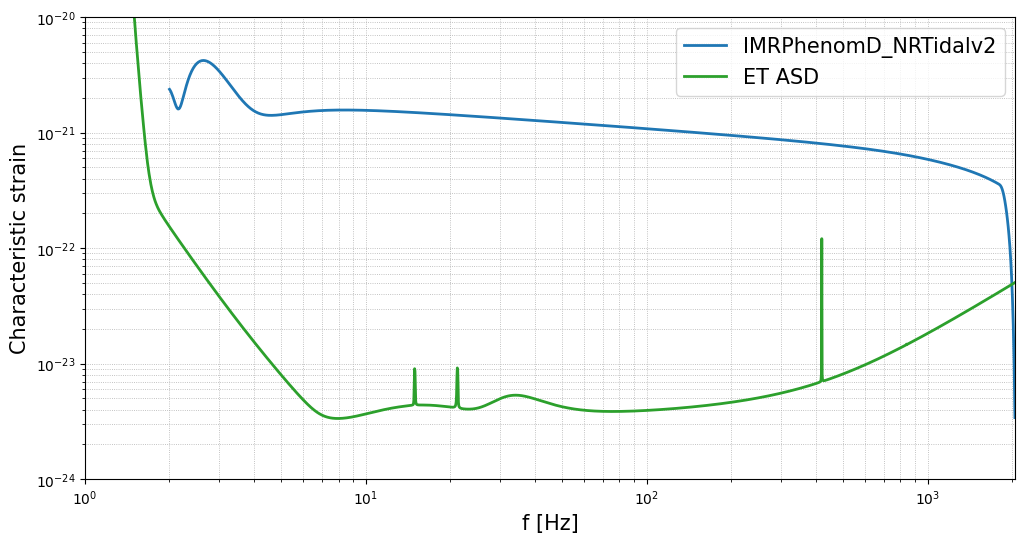

In [12]:
# The projected amplitude is stored in the signal variable
# We have 3 columns as ET is made of 3 detectors
signal1, signal2, signal3 = signal[:, 0], signal[:, 1], signal[:, 2]
signal_ampl = np.sqrt(np.abs(signal1)**2. + np.abs(signal2)**2. + np.abs(signal3)**2.)

# The PSD of the ET-D detector is stored in the detector_psd folder
# We need to specify the path to the file
psd_et = np.loadtxt('GWFish/detector_psd/ET_psd.txt', usecols=[0,1])
frequencyvector = network.detectors[0].frequencyvector[:, 0]

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(frequencyvector, 2. * frequencyvector * signal_ampl, 
        linewidth=2., label='%s' %(waveform_model))
ax.plot(psd_et[:,0], np.sqrt(psd_et[:,0]) * np.sqrt(psd_et[:,1]), linewidth = 2.0, color = 'C2', label = 'ET ASD')

ax.set_xlim(1.,frequencyvector[-1])
ax.set_ylim(1e-24, 1e-20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('f [Hz]', fontsize=15)
ax.set_ylabel(r'Characteristic strain', fontsize=15)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend(loc='upper right', fontsize=15, ncol=1, fancybox=True)

plt.show()

### A note on characteristic strain

The characteristic strain is a particular combination of signal/ASD with frequency so that the output is adimensional and the area in between the signal and the detector's densitivity curve can be interpreted as SNR:

$$
SNR^2 = 4\int\frac{h(f)h^*(f)}{S_n}df
$$

Therefore:

$$
h_c = 2f|h| \quad \text{and} \quad S_c = \sqrt{f}\sqrt{PSD}
$$

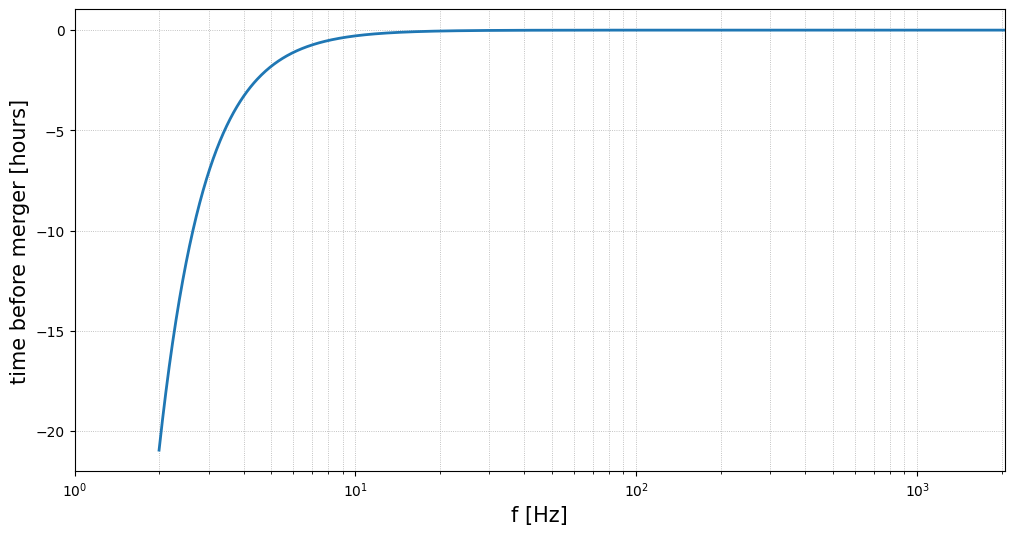

In [13]:
# Plot the time before merger as a function of frequency
fig, ax = plt.subplots(figsize = (12,6))
conv_to_hours = 3600
ax.plot(frequencyvector, (t_of_f - parameters['geocent_time'].iloc[0]) / conv_to_hours, linewidth = 2.)

ax.set_xlim(1.,frequencyvector[-1])
ax.set_xscale('log')
ax.set_xlabel('f [Hz]', fontsize = 15)
ax.set_ylabel(r'time before merger [hours]', fontsize=15)
plt.grid(linestyle = 'dotted', linewidth = '0.6', which = 'both')

plt.show()

### The ```analyze_and_save_to_txt``` function: save results to file and more

In [14]:
!mkdir gwfish_results

The difference with respect to the ```compute_network_errors``` function is that one can pass different network combinations and get results files for each of them. This means that if your detectors list is something like ```['LHO', 'LLO', 'VIR', 'CE1', 'ET']``` and you want to create 3 different networks out of it, i.e. ```['LHO', 'LLO', 'VIR']```, ```['CE1', 'ET']``` and ```['ET']``` alone, then one should inizialize the ```analyze_and_save_to_txt``` function as follows:

```
network = gw.detection.Network(detector_ids = ['LHO', 'LLO', 'VIR', 'CE1', 'ET'], detection_SNR = (0., 8.))
```

and then specify the different network combinations:

```
sub_network_ids_list = [[0, 1, 2], [3, 4], [4]]
```

In [15]:
data_folder = 'gwfish_results'
network = gw.detection.Network(detector_ids = ['ET'], detection_SNR = (0., 8.))
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters, 
                                        sub_network_ids_list = [[0]],
                                        population_name = 'BNS',
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = True)

100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


In [16]:
fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_ET_BNS_SNR8.npy')

In [17]:
errors = pd.read_csv(data_folder + '/' + 'Errors_ET_BNS_SNR8.txt', delimiter = ' ')

In [18]:
# One can access all the column names of the errors output file:
errors.keys()

Index(['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'theta_jn',
       'ra', 'dec', 'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1',
       'lambda_2', 'err_mass_1', 'err_mass_2', 'err_luminosity_distance',
       'err_theta_jn', 'err_dec', 'err_ra', 'err_psi', 'err_phase',
       'err_geocent_time', 'err_a_1', 'err_a_2', 'err_lambda_1',
       'err_lambda_2', 'err_sky_location'],
      dtype='object')

Same errors as before just save to a .txt file:

In [19]:
errors

,network_SNR,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,...,err_dec,err_ra,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,636.215709,1.51,1.255,43.75,2.545,3.446,-0.4081,0.0,0.0,1.187000e+09,...,0.003271,0.00389,0.1185,0.2396,0.00008,0.07078,0.08869,3849.0,6926.0,0.000037


### A quick test

One would expect that the Fisher matrix entry corresponding to dL-dL should be approximated by the ratio between the SNR and the luminosity distance squared as follows:

$$
\frac{1}{SNR} = \frac{\Delta d_L}{d_L}
$$

where $\Delta d_L = \sqrt{\left[F\right]^{-1}_{d_L,d_L}}$, with $F$ the Fisher matrix.

This can be derived from the fact that $\partial_{d_L}h = -\frac{1}{d_L}h$ and 
$$\frac{1}{\left(\Delta d_L\right)^2} \sim F_{d_L,d_L}=\langle \partial_{d_L}h|\partial_{d_L}h\rangle \sim \frac{SNR^2}{d_L^2}$$

where the inverse of the error on distance is the corresponding entry of the Fisher matrix $F_{d_L,d_L}$ (assuming correlations are negligible).

A rough approximation in literature takes: $\frac{\Delta d_L}{d_L} \sim \frac{2}{SNR}$.

In [20]:
my_fisher = fisher_matrix[0, :, :]
print('We expect Delta dL/dL to scale as 1/SNR')
print('fisher matrix dL-dL: ', my_fisher[2, 2])
print('(SNR/dL)^2: ', (errors['network_SNR'].iloc[0] / errors['luminosity_distance'].iloc[0])**2)

We expect Delta dL/dL to scale as 1/SNR
fisher matrix dL-dL:  211.49554098057754
(SNR/dL)^2:  211.47189728538135


### Corner plot

Using the covariance matrix one show all the correlations between pairs of parameters in a corner plot. Using as inputs the injected values and the covariance matrix, one samples from a multivariate Gaussian distribution and plot the samples.

/var/folders/2f/xs1ws1zx6kz2y5t39btv9b6h0000gn/T/ipykernel_1621/2245603356.py:25: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))


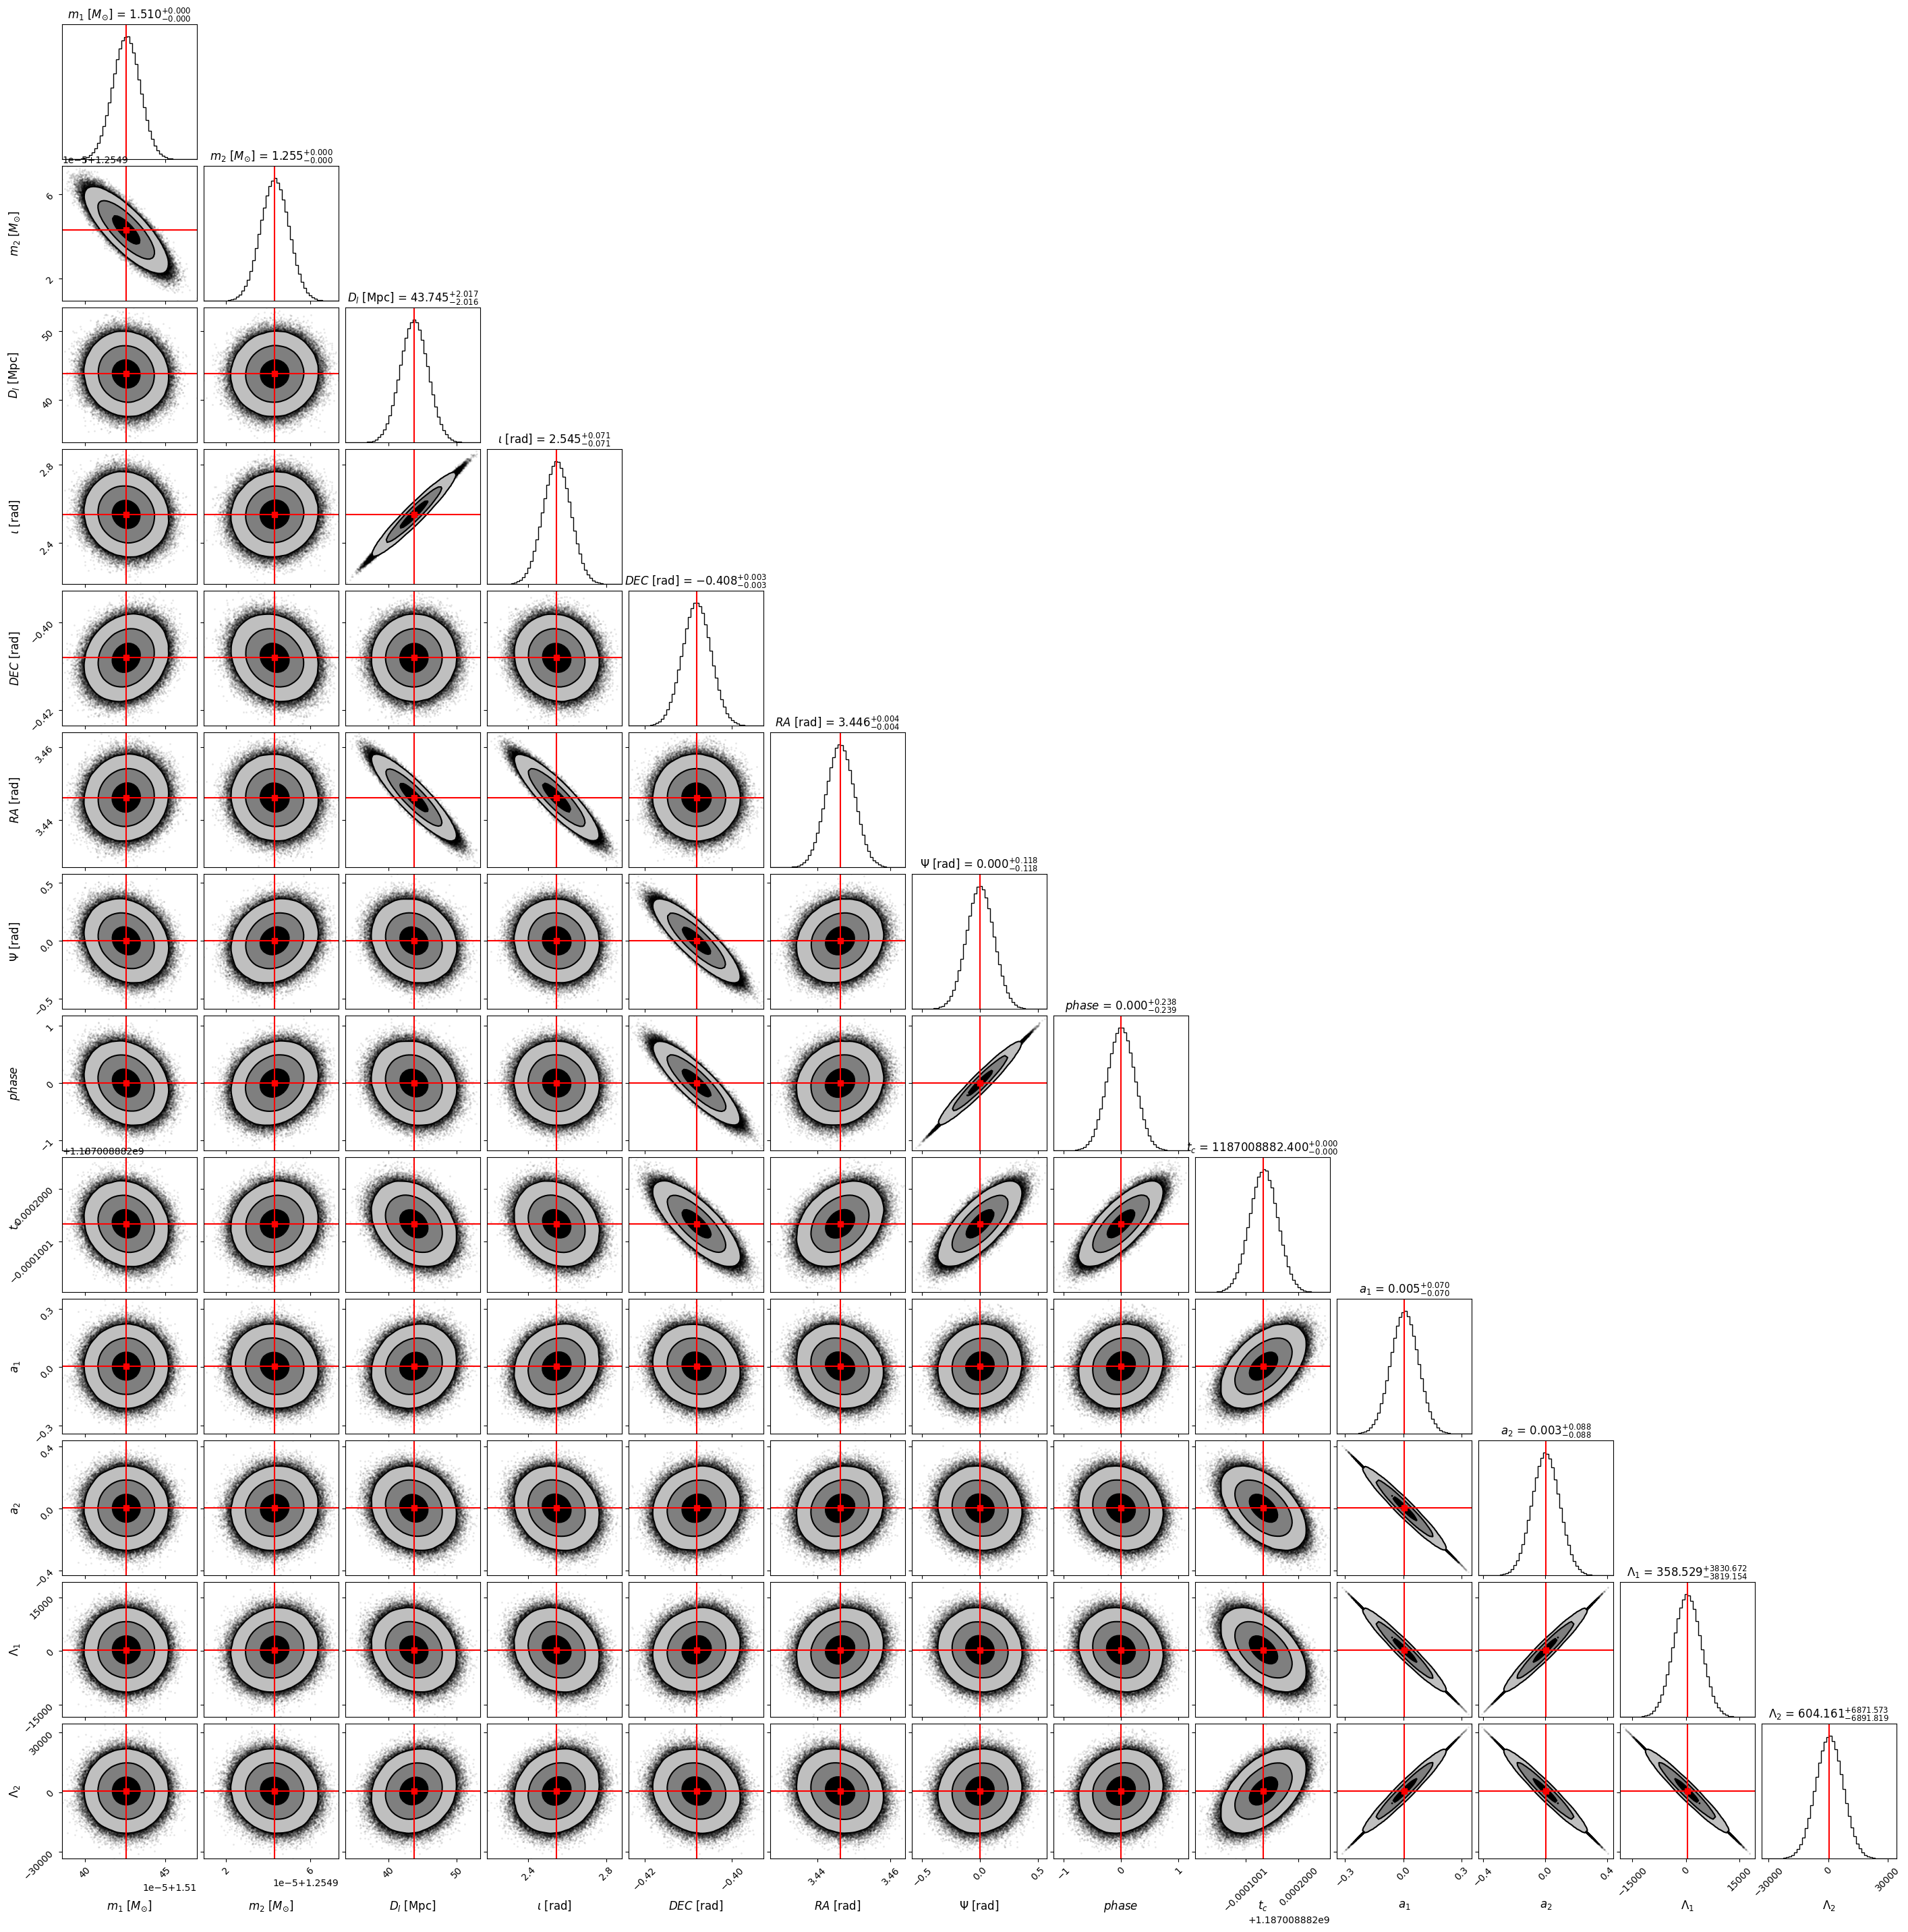

In [21]:
CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours. 
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = 12), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 12), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )
corner_lbs = [r'$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$', '$D_l$ [Mpc]',
                '$\iota$ [rad]', '$DEC$ [rad]', '$RA$ [rad]', '$\Psi$ [rad]',
                 '$phase$', '$t_c$', '$a_1$', '$a_2$', '$\Lambda_1$', '$\Lambda_2$']

mean_lbs = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec', 'ra', 'psi',
            'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1', 'lambda_2']
mean_values = parameters[mean_lbs].iloc[0] # mean values of the parameters
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_ET_BNS_SNR8.npy')[0, :, :]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))
fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red',
                    **CORNER_KWARGS)
plt.show()

## Some exercises

### 1. Compare waveforms
Take the GW170817-like event we have analyzed so far and try to compare the error estimate using two different waveforms (for example the basic TaylorF2 and the IMRPhenomHM)

### 2. Compare networks
Take our GW17817-like event and compare results using ET alone and the O5-like network composed of LIGO-Hanford (LHO), LIGO Livingston (LLO), Virgo (VIR) and KAGRA (KAG). What happens to sky localization?

### A quick note on detectors setup

Detectors are all described in the ```.yaml``` file. The general settings are as follows (in case you want to customize your own detector):

```
ET: # name label of the detector
            lat:              (40 + 31. / 60 ) * np.pi / 180.
            lon:              (9 + 25. / 60) * np.pi / 180.
            opening_angle:    np.pi / 3.
            azimuth:          70.5674 * np.pi / 180.
            psd_data:         ET_psd.txt # file containg two columns: frequency, psd
            duty_factor:      0.85
            detector_class:   earthDelta # for triangle-shaped detector or earthL if usual-shape detector
            plotrange:        3, 1000, 1e-25, 1e-20
            fmin:             2. # minimum frequency of the detector
            fmax:             2048. # maximum frequency of the detector
            spacing:          geometric
            df:               1./16.
            npoints:          1000
```

The ```spacing``` variable can either be ```geometric``` (logarithmic spacing of the frequency vector for waveform evaluation with a number of points specified by the ```npoints``` variable, faster solution) or ```linear``` (linear spacing of the frequency vector to evaluate the waveform with spacing given by ```df```, slower solution)

# GWFish Tutorial: BBH Population Analysis
The functions are the same explained in the previous tutorial, but applied to a population sample instead of a single event

In [22]:
detectors_pop = ['ET']
network_pop = gw.detection.Network(detector_ids = detectors_pop, detection_SNR = (0., 8.))
waveform_model_pop = 'IMRPhenomHM'
fisher_parameters_pop = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'phase', 'geocent_time', 'a_1', 'a_2']

In [23]:
data_file = 'my_sample_BBH_data' # or 'my_sample_BNS_data' for BNS population sample
pop_file_url = 'https://raw.githubusercontent.com/u-dupletsa/ET-ad-Assisi-2024-Scienza-e-Tecnologia/main/data/' + data_file + '.txt'

In [24]:
bbh_data = pd.read_csv(pop_file_url, delimiter = ' ')
bbh_df = pd.DataFrame(bbh_data)
bbh_df

,mass_1,mass_2,luminosity_distance,redshift,theta_jn,dec,ra,psi,phase,geocent_time,a_1,a_2
0,9.9763,7.8050,47665.472928,4.9989,0.845809,-0.868201,3.192623,4.680632,3.658932,1.580830e+09,0.0979,0.1170
1,7.2665,6.8762,18748.089088,2.2870,1.013150,-0.412954,2.299121,2.929876,2.319665,1.599736e+09,0.0580,0.4370
2,20.2790,8.7665,2475.523144,0.4353,0.849345,0.544142,1.759793,1.210486,0.618035,1.596188e+09,0.1894,0.0385
3,21.9110,10.4350,7930.765906,1.1341,2.053660,0.398778,5.126561,1.830399,4.774107,1.598699e+09,0.2077,0.1606
4,5.8564,5.8348,11726.537632,1.5579,1.793405,0.566255,3.001951,3.711388,0.652400,1.586375e+09,0.1883,0.1025
...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.7409,8.1016,26410.833906,3.0379,1.754477,0.057924,3.711182,2.525835,3.444244,1.581576e+09,0.0630,0.1098
96,19.5973,17.5301,36483.304056,3.9838,2.247829,0.496231,5.074968,0.579237,1.686690,1.578867e+09,0.1171,0.1884
97,19.9260,19.8030,99449.463516,9.4540,2.101227,1.026139,5.387957,1.826594,1.212988,1.600986e+09,0.3187,0.1163
98,20.7580,20.2280,49249.925478,5.1405,1.277060,-0.476073,5.112159,5.361029,0.637661,1.579479e+09,0.2354,0.1213


In [25]:
!mkdir pop_gwfish_results

In [26]:
data_folder_pop = 'pop_gwfish_results'
gw.fishermatrix.analyze_and_save_to_txt(network = network_pop,
                                        parameter_values  = bbh_df,
                                        fisher_parameters = fisher_parameters_pop, 
                                        sub_network_ids_list = [[0]],
                                        population_name = 'BBH',
                                        waveform_model = waveform_model_pop,
                                        save_path = data_folder_pop,
                                        save_matrices = False)

100%|██████████| 100/100 [03:25<00:00,  2.05s/it]


In [27]:
pop_errors = pd.read_csv(data_folder_pop + '/' + 'Errors_ET_BBH_SNR8.txt', delimiter = ' ')
pop_errors

,network_SNR,mass_1,mass_2,luminosity_distance,redshift,theta_jn,dec,ra,psi,phase,...,err_luminosity_distance,err_theta_jn,err_dec,err_ra,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_sky_location
0,19.698148,9.976,7.805,47670.0,4.9990,0.8458,-0.86820,3.193,4.6810,3.6590,...,222500.0,0.44340,22.3200,14.3400,11.7600,1.3540,0.094020,0.34690,0.44830,593.9000
1,9.452086,7.266,6.876,18750.0,2.2870,1.0130,-0.41300,2.299,2.9300,2.3200,...,70220.0,2.11100,0.9429,1.0410,4.0180,9.3790,0.014410,1.66600,1.75300,2.3370
2,169.700138,20.280,8.767,2476.0,0.4353,0.8493,0.54410,1.760,1.2100,0.6180,...,2722.0,0.04154,6.4790,2.2640,1.3550,0.1473,0.021950,0.02793,0.05707,39.2500
3,24.666298,21.910,10.440,7931.0,1.1340,2.0540,0.39880,5.127,1.8300,4.7740,...,7335.0,0.43580,0.1873,0.3465,0.8258,2.2110,0.005191,0.13600,0.22430,0.1715
4,16.371899,5.856,5.835,11730.0,1.5580,1.7930,0.56630,3.002,3.7110,0.6524,...,27540.0,0.07139,6.6810,6.5570,4.1700,0.2064,0.050580,0.74750,0.75770,115.6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,9.526788,8.741,8.102,26410.0,3.0380,1.7540,0.05792,3.711,2.5260,3.4440,...,258400.0,1.69700,8.2420,14.5800,5.5320,2.4840,0.228500,0.77750,0.85260,333.1000
87,17.988264,19.600,17.530,36480.0,3.9840,2.2480,0.49620,5.075,0.5792,1.6870,...,42110.0,0.49740,0.5674,0.1640,3.0500,5.9540,0.011700,0.38210,0.42590,0.2372
88,18.210976,19.930,19.800,99450.0,9.4540,2.1010,1.02600,5.388,1.8270,1.2130,...,173900.0,0.39020,10.5100,8.4030,5.9950,2.8150,0.043220,0.40760,0.43910,126.1000
89,21.648181,20.760,20.230,49250.0,5.1410,1.2770,-0.47610,5.112,5.3610,0.6377,...,515000.0,0.32700,34.2400,26.9500,17.5700,1.0230,0.222400,0.31510,0.33670,2552.0000


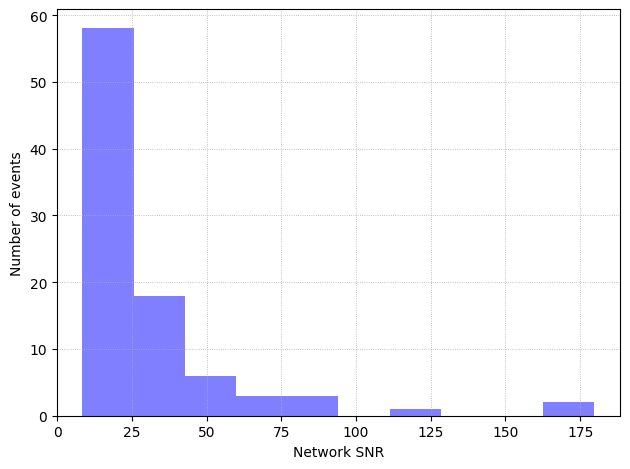

In [28]:
plt.hist(pop_errors['network_SNR'], bins = 10, color = 'blue', alpha = 0.5, linewidth = 2)
plt.xlabel('Network SNR')
plt.ylabel('Number of events')
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
plt.tight_layout()
plt.show()

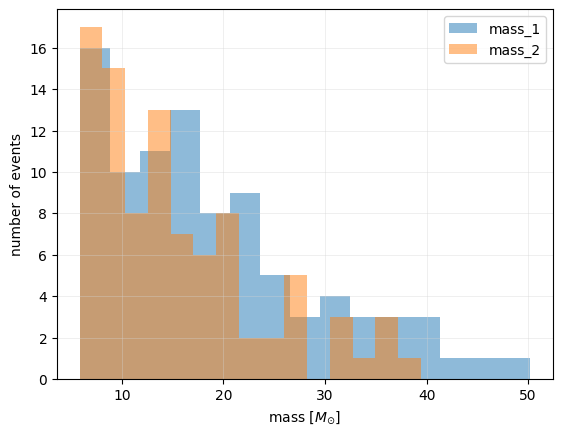

In [29]:
plt.hist(pop_errors['mass_1'], bins = 15, label = 'mass_1', alpha= 0.5)
plt.hist(pop_errors['mass_2'], bins = 15, label = 'mass_2', alpha= 0.5)
plt.legend()
plt.xlabel('mass [$M_{\odot}$]')
plt.ylabel('number of events')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

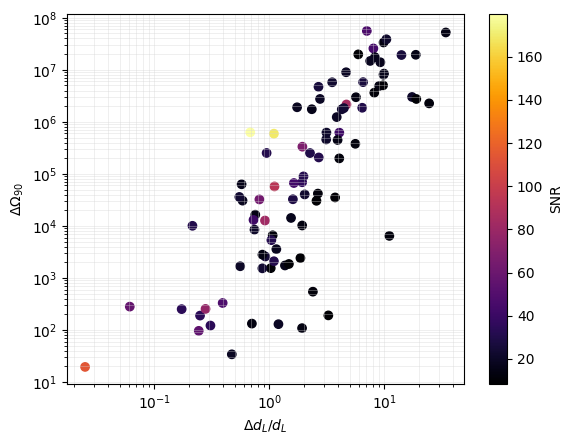

In [30]:
percentile_pop = 90
sky_loc_90cl_pop = pop_errors['err_sky_location'] * gw.fishermatrix.sky_localization_percentile_factor(percentile_pop)
sc = plt.scatter(pop_errors['err_luminosity_distance'] / pop_errors['luminosity_distance'],
                 sky_loc_90cl_pop, c = pop_errors['network_SNR'], cmap = 'inferno')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\Delta d_L/d_L$')
plt.ylabel('$\Delta \Omega_{%s}$' %int(percentile))
plt.colorbar(sc, label = 'SNR')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

## Some more exercises

### 1. Analyze BNS population

After loading the BNS population, do the Fisher analysis and redo the plots done for the BBH population

In [ ]:
data_file = 'my_sample_BNS_data'
bns_pop_url = 'https://raw.githubusercontent.com/u-dupletsa/ET-ad-Assisi-2024-Scienza-e-Tecnologia/main/data/' + data_file + '.txt'
bns_data = pd.read_csv(bns_pop_url, delimiter = ' ')
bns_data = pd.DataFrame(bns_data)
bns_data

### 2. Create your own population

Follow the guidelines to create your own population sample and run it with GWFish:

In [ ]:
# Example for BNS population
nev = 50 # number of events
my_dict = {}
my_dict['redshift'] = np.random.uniform(0.001, 0.1, nev)
my_dict['mass_1'] = np.random.uniform(1.1, 2.5, nev)
my_dict['mass_2'] = np.random.uniform(1.1, 2.5, nev)
my_dict['luminosity_distance'] = Planck18.luminosity_distance(my_dict['redshift']).value
my_dict['theta_jn'] = np.arccos(np.random.uniform(-1., 1., nev))
my_dict['ra'] = np.random.uniform(0., 2 * np.pi, nev)
my_dict['dec'] = np.arcsin(np.random.uniform(-1., 1., nev))
my_dict['psi'] = np.random.uniform(0., np.pi, nev)
my_dict['phase'] = np.random.uniform(0., 2 * np.pi, nev)
my_dict['geocent_time'] = np.random.uniform(1577491218, 1609027217, nev)
my_dict['a_1'] = np.random.uniform(0., 0.1, nev)
my_dict['a_2'] = np.random.uniform(0., 0.1, nev)
my_dict['lambda_1'] = np.random.uniform(100., 1000., nev)
my_dict['lambda_2'] = np.random.uniform(100., 1000., nev)
aux_mass = my_dict['mass_1']
my_dict['mass_1'] = np.maximum(aux_mass, my_dict['mass_2'])
my_dict['mass_2'] = np.minimum(aux_mass, my_dict['mass_2'])
my_dict = pd.DataFrame(my_dict)
my_dict